# 1A. Quick-start

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.3* onwards  
> Last update: *2024/07/08*

**Table of contents**

* [1.1. Loading ADI data](1.1.-Loading-ADI-data)
* [1.2. PSF subtraction](1.2.-PSF-subtraction)
    - [1.2.1. median-ADI](1.2.1.-median-ADI)
    - [1.2.2. Full-frame PCA](1.2.2.-Full-frame-PCA)
* [1.3. Is the point source significant?](1.3.-Is-it-significant?)

This quick-start tutorial shows:

- how to load Angular Differential Imaging (ADI) datacubes; 
- how to use algorithms implemented in VIP to model and subtract the stellar halo, and search for faint circumstellar companions in the post-processed images;
- how to quickly assess the significance of a point source found in a post-processed image.

-----------

Let's assume ``VIP`` is properly installed. If not, follow the instructions [here](https://vip.readthedocs.io/en/latest/Installation-and-dependencies.html). We import the package along with other useful packages which are installed together with ``VIP``. The ``hciplot`` package aims to be the "Swiss army" solution for plotting and visualizing multi-dimensional high-contrast imaging datacubes.

In [1]:
import vip_hci as vip

from hciplot import plot_frames, plot_cubes
from matplotlib import pyplot as plt
import numpy as np

In the following box we check that your version of VIP is recent enough to run this notebook.

In [2]:
from packaging import version
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.3 or above to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.6


```{warning}  
Your version of VIP should be >=1.0.3 to run this notebook. If not, close the notebook and run for example `pip install vip_hci --upgrade` in your terminal.
```

`VIP` also allows interactive work with `DS9` provided that it's installed on your system along with ``pyds9``. A `DS9` session (window) can be started with: 

```python
from vip_hci.vip_ds9 import Ds9Window
ds9 = Ds9Window()
```

```{note}   
If the above fails but you have `pyds9` installed (`vip_ds9` is only a wrapper around `pyds9`), you may find the [following troubleshooting tips](https://community.lsst.org/t/ds9-communication-via-xpa/2242) useful (e.g. step 4).
```

The *ds9* methods will allow interaction with the `DS9` window. For example, for sending an array to the `DS9` window you can then simply use:

```ds9.display(2d_or_3d_array)```

`pyds9` is an optional dependency of VIP. Instead, one can also use ```hciplot```'s ```plot_frames``` and ```plot_cubes``` routines - as illustrated in all the tutorial notebooks - for visualization and interaction with your images/datacubes.

(1.1.-Loading-ADI-data)=
## 1.1. Loading ADI data

In order to demonstrate the capabilities of ``VIP``, you can find in the 'dataset' folder of the `VIP_extras` repository: 
- a toy Angular Differential Imaging (ADI) datacube of images (`naco_betapic_cube_cen.fits`),
- the derotation angles required to align true north in each image of the datacube (`naco_betapic_derot_angles.fits`),
- a non-coronagraphic point spread function (`naco_betapic_psf.fits`).

The dataset was obtained with the NACO instrument of the Very Large Telescope (VLT). This is an L'-band dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract), obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

Let's load a couple of utilities related to FITS files:

In [3]:
from vip_hci.fits import open_fits, write_fits, info_fits
from astropy.utils.data import download_file

To inspect or retrieve the data, the easiest way is to provide their local path to the relevant functions in VIP - as illustrated with the commented code lines below.

Here we use the `download_file` utility of `astropy` with the `cache` option - which equivalently stores the local path to the file after downloading the data from an online repository:

In [4]:
from astropy.utils.data import download_file

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/naco_betapic_cube_cen.fits".format(url_d), cache=True)
f2 = download_file("{}/naco_betapic_psf.fits".format(url_d), cache=True)
f3 = download_file("{}/naco_betapic_derot_angles.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/naco_betapic_cube_cen.fits'
#f2 = '../datasets/naco_betapic_psf.fits'
#f3 = '../datasets/naco_betapic_derot_angles.fits'

Let's first inspect the FITS file using the `info_fits` function:

In [5]:
from vip_hci.fits import info_fits
info_fits(f1)

Filename: /Users/bhavanapoli/.astropy/cache/download/url/916f9dc5548cc5a02ae424dbd987fc6a/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (101, 101, 61)   float32   


The FITS file contains an ADI datacube of 61 images 101x101 px across. The length of the derotation angle vector for this observation is thus also 61.

```{important}                                       
The *convention* in VIP is to consider **derotation angles** as input for ADI-based post-processing algorithms, not **parallactic angles**. Derotation angles are the angles to be applied to the observed images (with positive offsets measured counter-clockwise) in order to align them with north up. These are essentially the *opposite* values of the parallactic angles plus some instrument-specific offsets. The additional offsets can correspond to any internal reflections affecting the orientation of the field of view, or to a correction for the true north orientation which may drift over time and requires dedicated instrumental calibrations. These additional offsets should be checked in the manual of the instrument you are using.
```

Now let's load all the data in memory with the `open_fits` function:

In [6]:
from vip_hci.fits import open_fits
cube = open_fits(f1)
psf = open_fits(f2)
angs = open_fits(f3)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)
FITS HDU-0 data successfully loaded. Data shape: (61,)


As a reminder, you can use '?' after a given function to know what it requires as input, and what it returns as output. For example, to know how to write a FITS file:

In [7]:
from vip_hci.fits import write_fits
write_fits?

Signature:
write_fits(
    fitsfilename,
    array,
    header=None,
    output_verify='exception',
    precision=<class 'numpy.float32'>,
    verbose=True,
)
Docstring:
Write array and header into FITS file.

If there is a previous file with the same filename then it's replaced.

Parameters
----------
fitsfilename : string
    Full path of the fits file to be written.
array : numpy ndarray or tuple of numpy ndarray
    Array(s) to be written into a fits file. If a tuple of several arrays,
    the fits file will be written as a multiple extension fits file
header : numpy ndarray, or tuple of headers, optional
    Header dictionary, or tuple of headers for a multiple extension fits
    file.
output_verify : str, optional
    {"fix", "silentfix", "ignore", "warn", "exception"}
    Verification options:
    https://docs.astropy.org/en/stable/io/fits/api/verification.html
precision : numpy dtype, optional
    Float precision, by default np.float32 or single precision float.
verbose : bool,

The `info_fits`, `open_fits` and `write_fits` functions are wrappers of `astropy.io.fits` functionalities.
After using `open_fits`, the FITS file is now a ndarray or ``numpy`` array in memory.

If you open the datacube with ds9 (or send it to the `DS9` window) and adjust the cuts you will see the beta Pic b planet moving on a circular trajectory, among similarly bright quasi-static speckle. Alternatively, you can use `hciplot.plot_cubes`:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
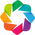

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 61]


BokehModel(combine_events=True, render_bundle={'docs_json': {'22e9ac50-22cd-422f-8cb1-862dac3e25d4': {'version…

In [8]:
%matplotlib inline
plot_cubes(cube, vmin=0, vmax=400, backend='bokeh')

Let's fit the PSF with a 2D Gaussian to infer the FWHM, determine the flux in a 1-FWHM size aperture, and get a flux-normalized PSF. This is done in the `normalized_psf` function defined in the forward modeling (`fm`) subpackage:

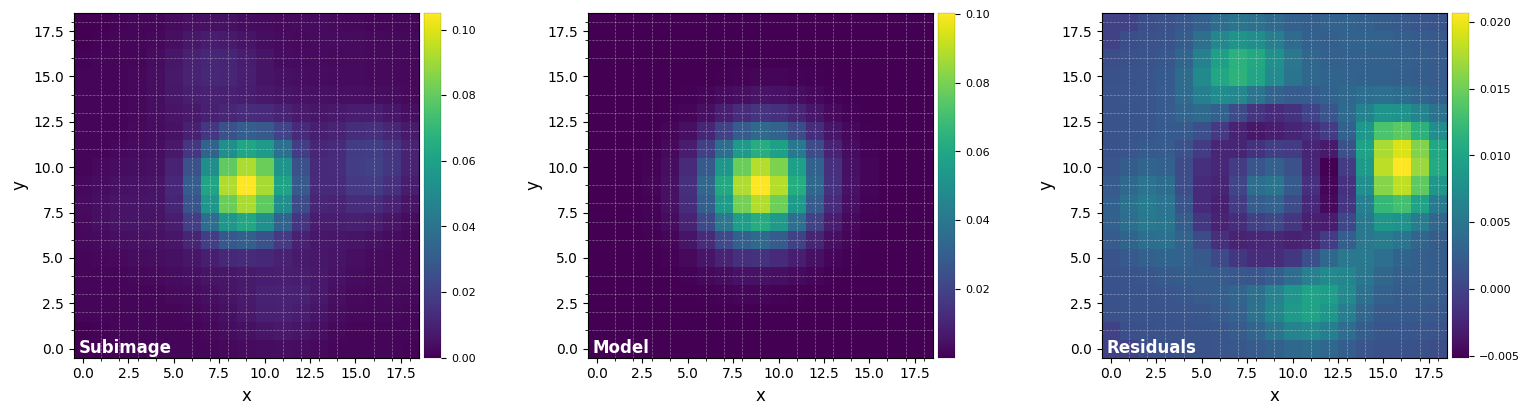

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.44618706050392

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307


In [9]:
%matplotlib inline
from vip_hci.fm import normalize_psf  # fm is the forward modeling subpackage, with various tools for the characterization of point sources and extended signals.

psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

In [10]:
print(fwhm_naco)

4.800919383981533


```{note}
The `normalize_psf` function performs internally a fine centering of the PSF. The input PSF should nevertheless already be centered within a few pixel accuracy for the fine centering to work.
```

Now let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `backend='matplotlib'` (default) allows paper-quality figures with annotations which can be saved, while `backend='bokeh'` enables interactive visualization.

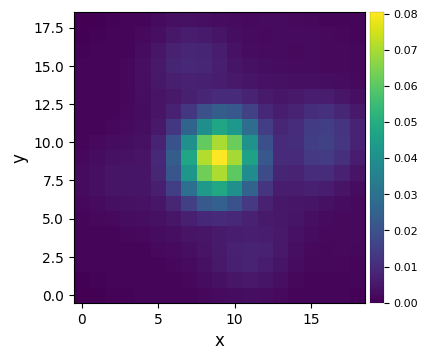

In [11]:
plot_frames(psfn, size_factor=4)#, backend='bokeh')

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [12]:
from vip_hci.config import VLT_NACO  # config is a subpackage with configuration files and parameter/dictionary definition

pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


(1.2.-PSF-subtraction)=
## 1.2. PSF subtraction

When loading the ADI cube above, we assumed all calibration and preprocessing steps were already performed. In particular, the star is assumed to be already centered in the images. If your data require additional calibration/preprocessing, check out tutorial `2. Pre-processing`.

```{important}                                         
VIP's convention regarding star centering is:

- for **odd** number of pixels along the x and y dimensions: the star centroid should correspond to the central pixel of the image;
- for **even** number of pixels: the star centroid should be located on coordinates (dim/2,dim/2) in 0-based indexing (i.e. on the top-right pixel of the 4 central pixels).
```

(1.2.1.-median-ADI)=
### 1.2.1. median-ADI

The most simple approach is to model the PSF with the median image of the ADI sequence, subtract it, then derotate and median-combine all residual images ([Marois et al. 2006](https://ui.adsabs.harvard.edu/abs/2006ApJ...641..556M/abstract)):

In [13]:
from vip_hci.psfsub import median_sub

fr_adi = median_sub(cube, angs)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-25 20:51:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:02.424426
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the final images:

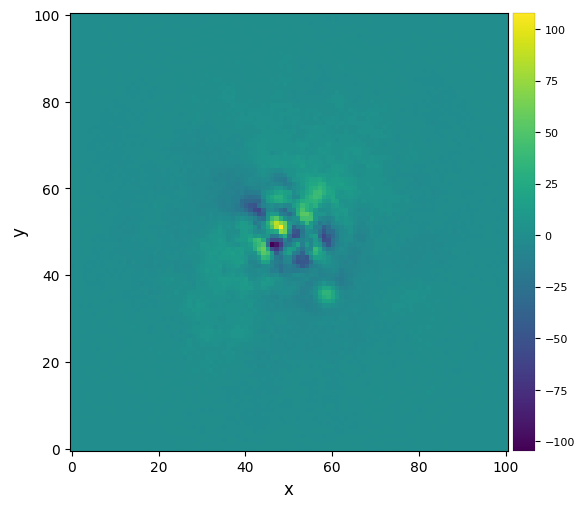

In [14]:
plot_frames(fr_adi)

Strong residuals can be seen near the center of the image, with a faint potential point source in the south-west (bottom right) of the final image.

```{note}
As per usual convention, north is up and east is left in all images shown in the tutorial. Note that for the images of some instruments, te x-axis may be flipped (i.e. east would be right instead of left). This is for example the case for Gemini/NICI or VLT/ERIS-NIX. Double-check your instrument manual.
```

(1.2.2.-Full-frame-PCA)=
### 1.2.2. Full-frame PCA

Now let's try the Principal Component Analysis (PCA) algorithm ([Amara & Quanz 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract), [Soummer et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract)), and set to 5 the number of principal components `ncomp` considered to create the model PSF.

In [15]:
from vip_hci.psfsub import pca    # psfsub is the subpackage containing PSF modeling and subtraction algorithms

fr_pca1 = pca(cube, angs, ncomp=5)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-25 20:51:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 5.687 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.038502
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:02.448576
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the final image. This time let's set the `grid` option on, to better read coordinates from the image. Alternatively, use the `backend='bokeh'` option for interactive reading:

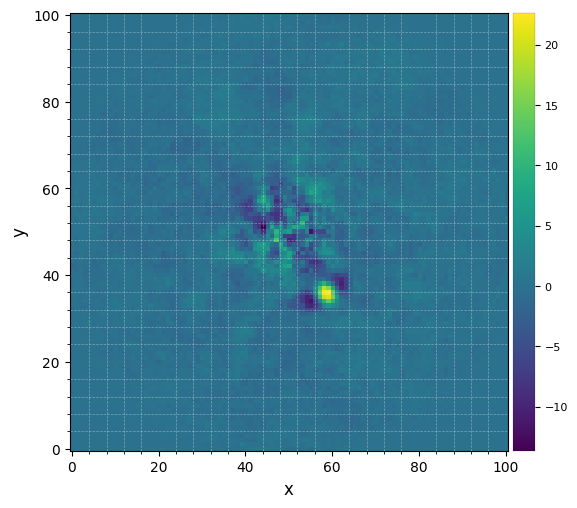

In [16]:
plot_frames(fr_pca1, grid=True)#, backend='bokeh')

The improvement is clear compared to previous reductions. Very low residuals are seen near the star, and the companion candidate appears as a bright point source surrounded by negative side-lobes.

(1.3.-Is-it-significant?)=
## 1.3. Is it significant?

Now let's see whether the candidate is significant. For that let's first set the x,y coordinates of the test point source based on the above image:

In [17]:
xy_b = (58.5,35.5)

Let's compute the signal-to-noise ratio at that location, following the definition in [Mawet et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract), using the appropriate function defined in the `metrics` subpackage:

In [18]:
from vip_hci.metrics import snr

snr1 = snr(fr_pca1, source_xy=xy_b, fwhm=fwhm_naco)
print(r"S/N = {:.1f}".format(snr1))

S/N = 7.7


One can also calculate a S/N ratio map over the whole image (this may take a couple of seconds depending on the size of your image):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-11-25 20:51:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


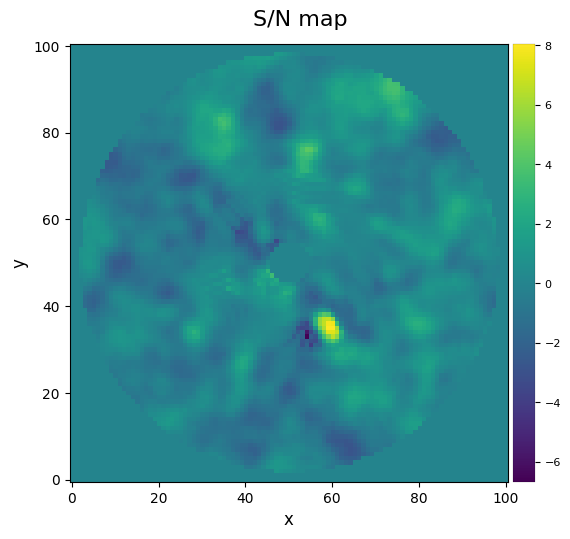

S/N map created using 4 processes
Running time:  0:00:06.334971
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [19]:
from vip_hci.metrics import snrmap

snrmap1 = snrmap(fr_pca1, fwhm_naco, plot=True)

```{warning}  
 S/N ratio is **not** the same as significance ([Mawet et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract)) !
```

Let's convert the measured S/N ratio (Students statistics) into the equivalent Gaussian "sigma" in terms of false alarm probability. This first involves calculating the radial separation of the candidate, for which we use the `frame_center` and `dist` convenience routines to infer the pixel coordinates of the center, and the radial separation of the point source, respectively:

In [20]:
from vip_hci.var import frame_center, dist   # var is a subpackage containing various utility routines

cy, cx = frame_center(snrmap1)
rad = dist(cy, cx, xy_b[1], xy_b[0])

Now let's use the `significance` routine in VIP to operate the conversion:

In [21]:
from vip_hci.metrics import significance

sig = significance(snr1, rad, fwhm_naco, student_to_gauss=True)

At a separation of 16.8 px (3.5 FWHM), S/N = 7.7 corresponds to a 5.2-sigma detection in terms of Gaussian false alarm probability.


**Congratulations!** The detection is significant! You obtained a conspicuous direct image of an exoplanet! Although from this image alone one cannot disentangle a true physically bound companion from a background star, this source has now been extensively studied: it corresponds to giant planet $\beta$ Pic b (e.g. [Lagrange et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...493L..21L/abstract), [Absil et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract)).

You're now ready for more advanced tutorials. If you wish to know more about:

- basic usage but using an object-oriented framework --> go to **[Tutorial 1B](https://vip.readthedocs.io/en/latest/tutorials/01B_quickstart_with_objects.html)**;
- pre-processing functionalities available in VIP (star centering, bad frame trimming, bad pixel correction...) --> go to **[Tutorial 2](https://vip.readthedocs.io/en/latest/tutorials/02_preproc.html)**;
- post-processing algorithms leveraging angular differential imaging --> go to **[Tutorial 3A](https://vip.readthedocs.io/en/latest/tutorials/03A_psfsub_ADI.html)** or **[3B](https://vip.readthedocs.io/en/latest/tutorials/03B_psfsub_ADI_as_objects.html)** (the latter for Object-Oriented example usage);
- metrics to evaluate the significance of a detection or the achieved contrast in your image --> go to **[Tutorial 4](https://vip.readthedocs.io/en/latest/tutorials/04_metrics.html)**;
- how to characterize a directly imaged companion --> go to **[Tutorial 5A](https://vip.readthedocs.io/en/latest/tutorials/05A_fm_planets.html)**;
- how to characterize a circumstellar disk --> go to **[Tutorial 5B](https://vip.readthedocs.io/en/latest/tutorials/05B_fm_disks.html)**;
- how to characterize a companion in a disk using JWST observations --> go to Tutorial 5C (to come soon);
- post-processing algorithms leveraging reference star differential imaging --> go to **[Tutorial 6](https://vip.readthedocs.io/en/latest/tutorials/06_psfsub_fm_RDI.html)**;
- post-processing algorithms leveraging spectral differential imaging --> go to **[Tutorial 7](https://vip.readthedocs.io/en/latest/tutorials/07_ifs_psfsub_fm_planets.html)**;
- the difference between FFT- and interpolation-based image operations (rotation, shifts, scaling) --> go to **[Tutorial 8](https://vip.readthedocs.io/en/latest/tutorials/08_imlib_and_interpolation.html)**;